# Time series

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from plots import *
from utils import *
from sird import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, dpc_province_df, pop_prov_df, prov_list_df = load_data(data_path)

In [5]:
# Estimate the forecastability

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

## Exploration TS: infected Firenze

In [6]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [7]:
tmp_df = covidpro_df[covidpro_df.Province == province]

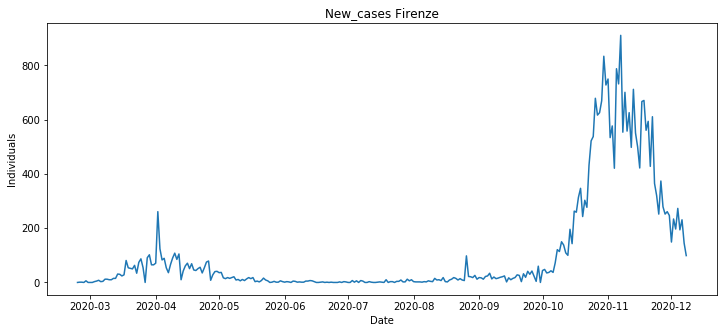

In [8]:
# Visualize TS

plt.figure(figsize=(12,5))
plt.plot(tmp_df[date], tmp_df[compart])
plt.gca().set(title=compart + " " + province, xlabel='Date', ylabel='Individuals')
plt.show()

In [9]:
tmp_df = tmp_df.set_index(date)

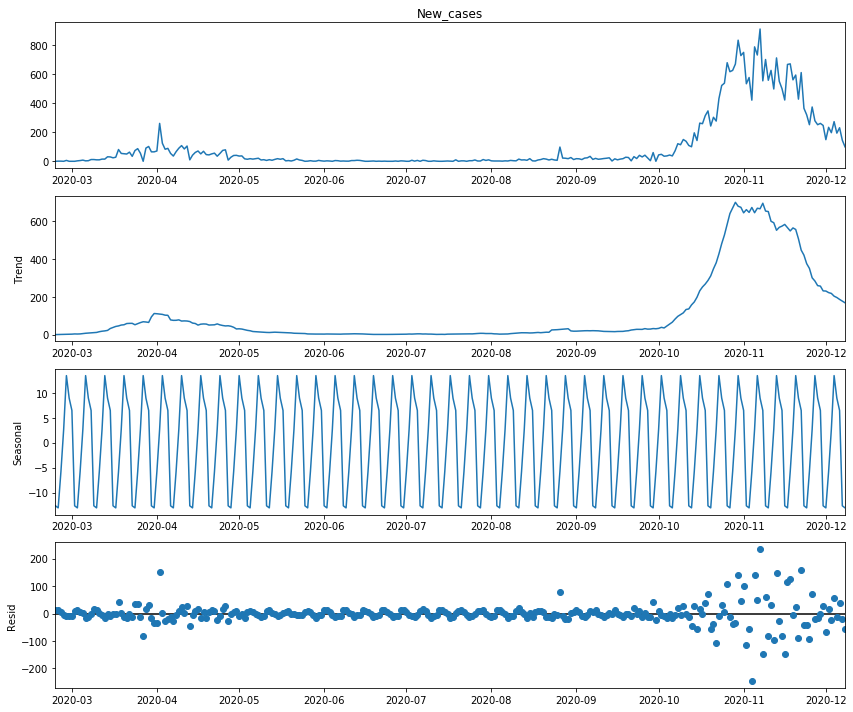

In [10]:
# Decompose TS

# Additive Decomposition
result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12,10)})
result_add.plot()
plt.show()

In [11]:
# Test for stationarity and trend stationarity

"""
ADF test: null hypothesis is the time series
possesses a unit root and is non-stationary
"""
result = adfuller(tmp_df[compart].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""
KPSS test: opposite of ADF
"""
result = kpss(tmp_df[compart].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.0398172752877484
p-value: 0.031339595269588565
Critial Values:
   1%, -3.45453261164607
Critial Values:
   5%, -2.8721859575020017
Critial Values:
   10%, -2.572442854861866

KPSS Statistic: 0.757675
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


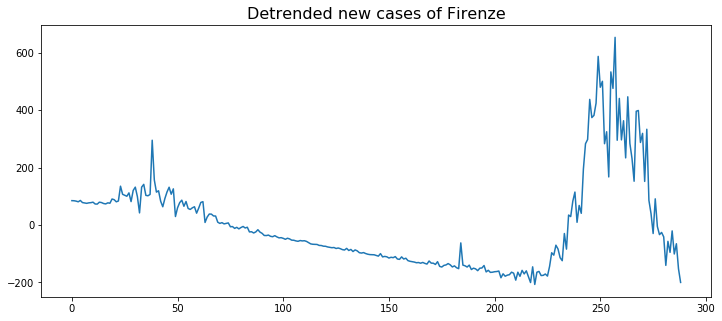

In [12]:
# Detrend by subtracting best leastsq fit
detrended = signal.detrend(tmp_df[compart].values)

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended new cases of ' + province, fontsize=16)
plt.show()

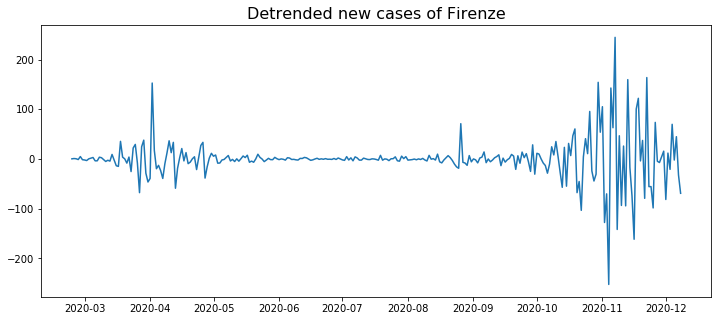

In [13]:
# Detrend by subtracting trend comp

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')
detrended = tmp_df[compart].values - result_add.trend

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended new cases of ' + province, fontsize=16)
plt.show()

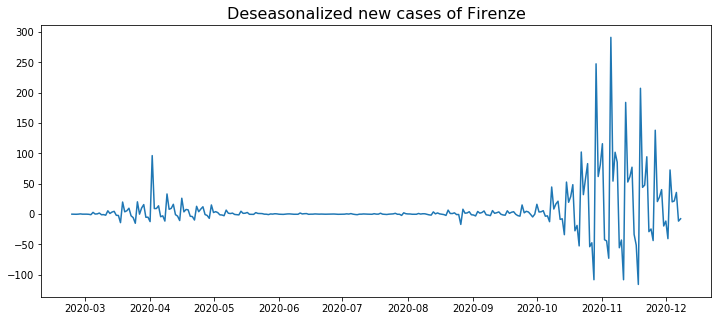

In [14]:
# Deseasonalize by subtracting trend

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

deseasonalized = tmp_df[compart].values / result_add.seasonal

plt.figure(figsize=(12,5))
plt.plot(deseasonalized)
plt.title('Deseasonalized new cases of ' + province, fontsize=16)
plt.plot()
plt.show()

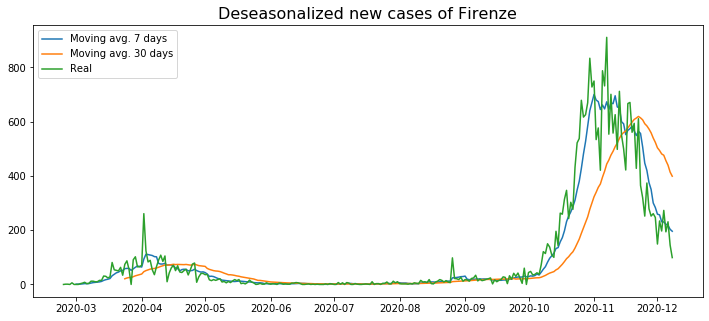

In [15]:
# Deseasonalize by taking mov. avg. with length = seasonal window

plt.figure(figsize=(12,5))
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=7).mean(), label='Moving avg. 7 days')
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=30).mean(), label='Moving avg. 30 days')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.title('Deseasonalized new cases of ' + province, fontsize=16)
plt.legend()
plt.show()

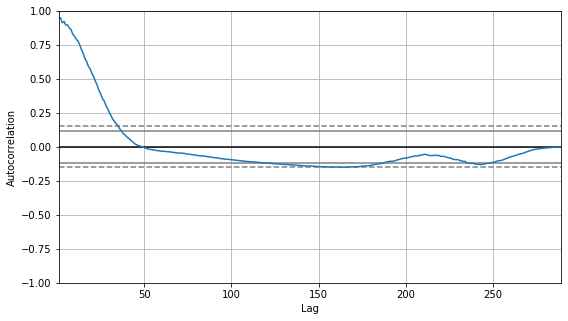

In [16]:
# Seasonality test
plt.rcParams.update({'figure.figsize': (9,5)})
autocorrelation_plot(tmp_df[compart].tolist())
plt.show()

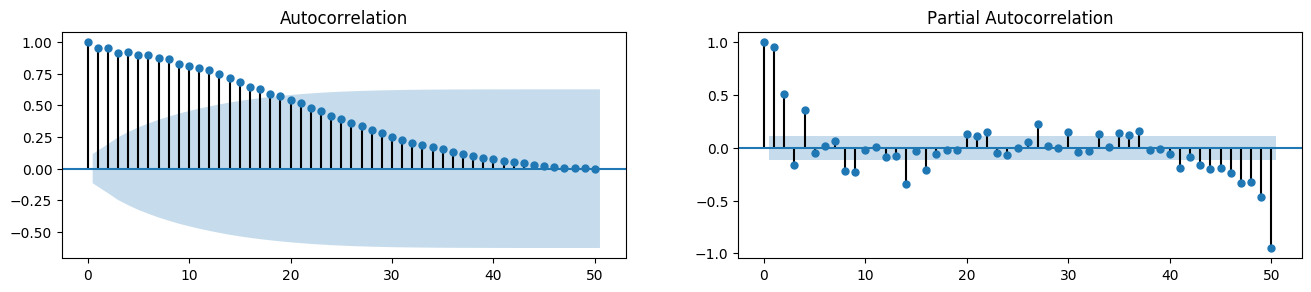

In [17]:
# Autocorrelation and partial autocorrelation

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(tmp_df[compart], nlags=50)
pacf_50 = pacf(tmp_df[compart], nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(tmp_df[compart].tolist(), lags=50, ax=axes[0])
plot_pacf(tmp_df[compart].tolist(), lags=50, ax=axes[1])
plt.show()

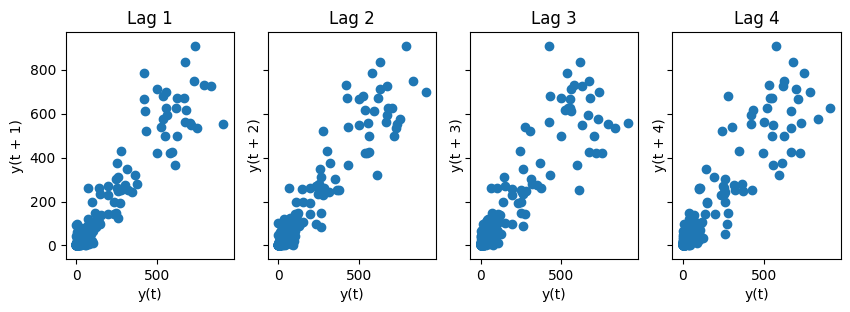

In [18]:
"""
Lag plots:

If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tmp_df[compart], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

plt.show()

In [19]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.08963868705514343
ApproxEn: 0.24724144657401426


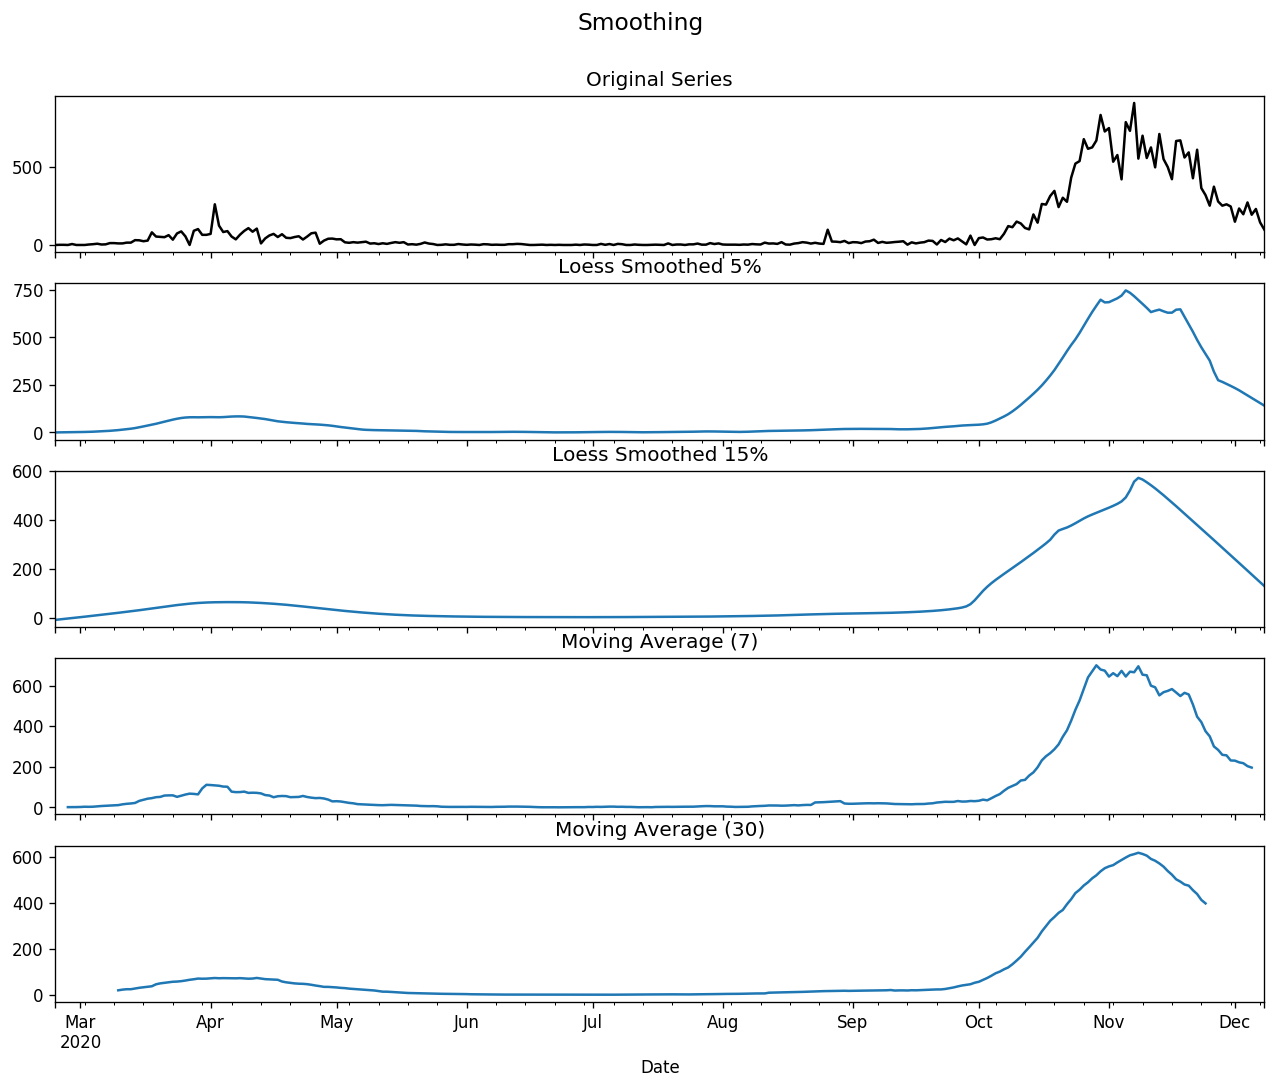

In [20]:
# Smoothing

# 1. Moving Average
df_ma1 = tmp_df[compart].rolling(7, center=True, closed='both').mean()
df_ma2 = tmp_df[compart].rolling(30, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.05)[:, 1], index=tmp_df.index, columns=[compart])
df_loess_15 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.15)[:, 1], index=tmp_df.index, columns=[compart])

# Plot
fig, axes = plt.subplots(5,1, figsize=(13, 10), sharex=True, dpi=120)
tmp_df[compart].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5[compart].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15[compart].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma1.plot(ax=axes[3], title='Moving Average (7)')
df_ma2.plot(ax=axes[4], title='Moving Average (30)')
fig.suptitle('Smoothing', y=0.95, fontsize=14)
plt.show()

In [21]:
"""
Granger causality tests:

Infected - Month
Infected - Deaths
"""

tmp_df = covidpro_df[covidpro_df.Province == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6421  , p=0.1052  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=2.6699  , p=0.1023  , df=1
likelihood ratio test: chi2=2.6576  , p=0.1031  , df=1
parameter F test:         F=2.6421  , p=0.1052  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3107  , p=0.7332  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=0.6323  , p=0.7289  , df=2
likelihood ratio test: chi2=0.6316  , p=0.7292  , df=2
parameter F test:         F=0.3107  , p=0.7332  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6090  , p=0.6097  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=1.8728  , p=0.5992  , df=3
likelihood ratio test: chi2=1.8667  , p=0.6005  , df=3
parameter F test:         F=0.6090  , p=0.6097  , df_denom=279, df_num=3


In [22]:
gc_res = grangercausalitytests(tmp_df[[compart, 'Deaths']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7475  , p=0.3880  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=0.7554  , p=0.3848  , df=1
likelihood ratio test: chi2=0.7544  , p=0.3851  , df=1
parameter F test:         F=0.7475  , p=0.3880  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7159  , p=0.0679  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=5.5281  , p=0.0630  , df=2
likelihood ratio test: chi2=5.4755  , p=0.0647  , df=2
parameter F test:         F=2.7159  , p=0.0679  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3205  , p=0.2679  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=4.0608  , p=0.2550  , df=3
likelihood ratio test: chi2=4.0323  , p=0.2580  , df=3
parameter F test:         F=1.3205  , p=0.2679  , df_denom=279, df_num=3


## Exploration TS: deaths Firenze

In [23]:
province = "Firenze"
compart = "Deaths"
date = 'Date'

In [24]:
tmp_df = covidpro_df[covidpro_df.Province == province]

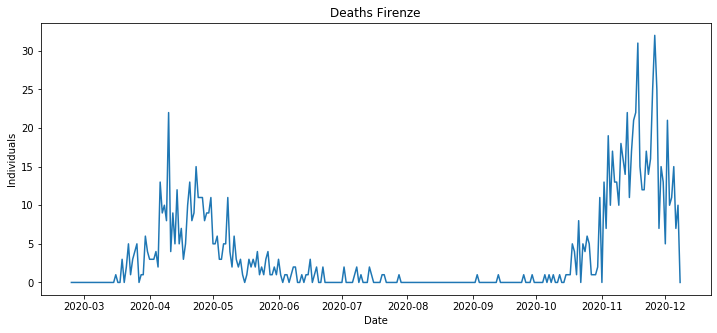

In [25]:
# Visualize TS

plt.figure(figsize=(12,5))
plt.plot(tmp_df[date], tmp_df[compart])
plt.gca().set(title=compart + " " + province, xlabel='Date', ylabel='Individuals')
plt.show()

In [26]:
tmp_df = tmp_df.set_index(date)

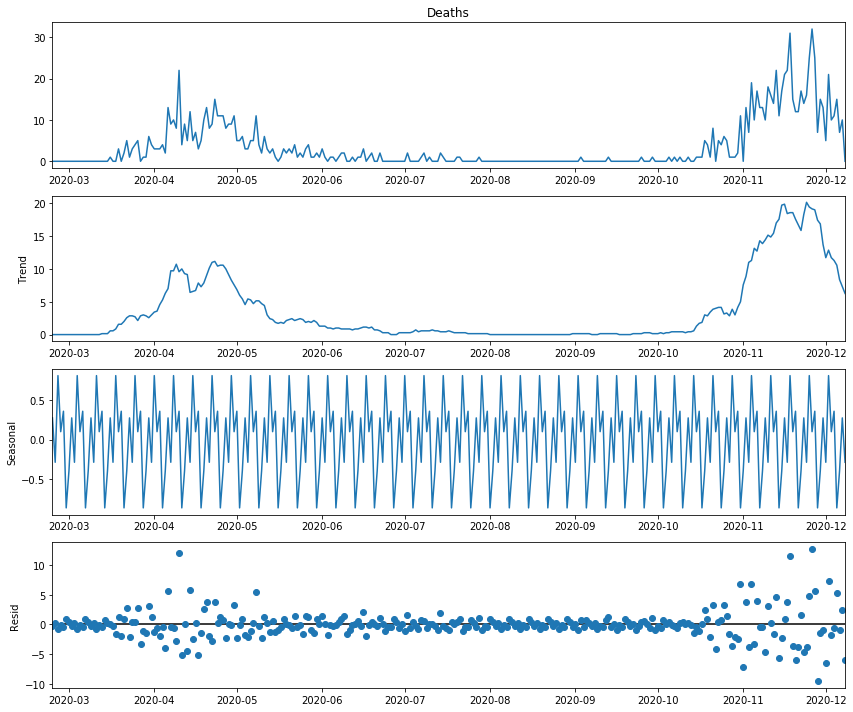

In [27]:
# Decompose TS

# Additive Decomposition
result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12,10)})
result_add.plot()
plt.show()

In [28]:
# Test for stationarity and trend stationarity

"""
ADF test: null hypothesis is the time series
possesses a unit root and is non-stationary
"""
result = adfuller(tmp_df[compart].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""
KPSS test: opposite of ADF
"""
result = kpss(tmp_df[compart].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.541443115453503
p-value: 0.10571354912567732
Critial Values:
   1%, -3.4546223782586534
Critial Values:
   5%, -2.8722253212300277
Critial Values:
   10%, -2.5724638500216264

KPSS Statistic: 0.364238
p-value: 0.092570
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


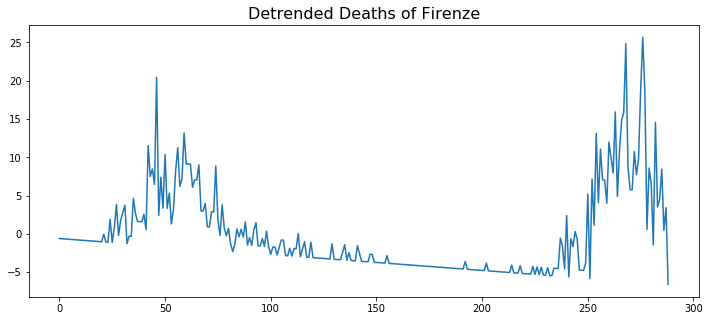

In [29]:
# Detrend by subtracting best leastsq fit
detrended = signal.detrend(tmp_df[compart].values)

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

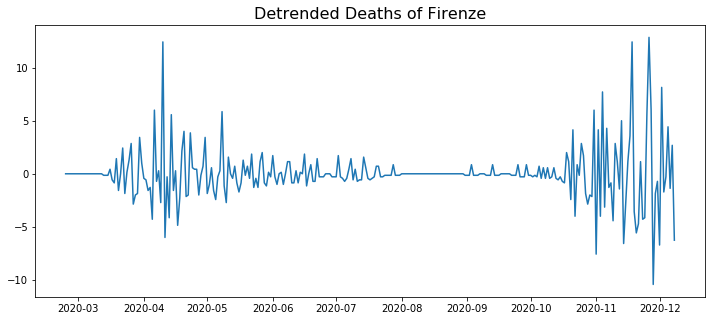

In [30]:
# Detrend by subtracting trend comp

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')
detrended = tmp_df[compart].values - result_add.trend

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

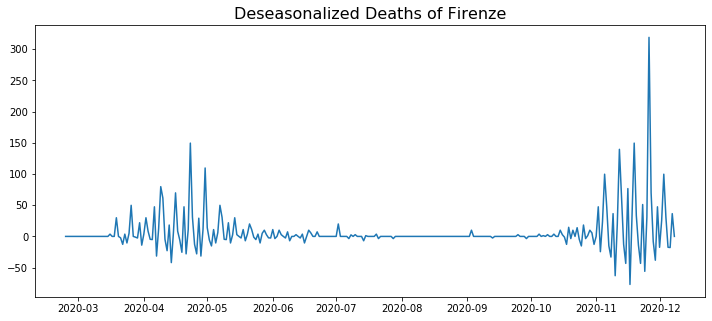

In [31]:
# Deseasonalize by subtracting trend

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

deseasonalized = tmp_df[compart].values / result_add.seasonal

plt.figure(figsize=(12,5))
plt.plot(deseasonalized)
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.plot()
plt.show()

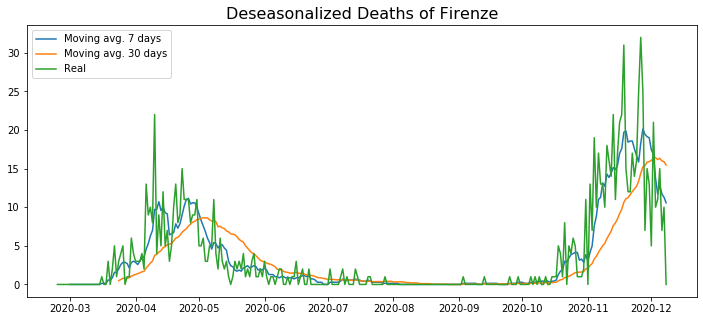

In [32]:
# Deseasonalize by taking mov. avg. with length = seasonal window

plt.figure(figsize=(12,5))
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=7).mean(), label='Moving avg. 7 days')
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=30).mean(), label='Moving avg. 30 days')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.legend()
plt.show()

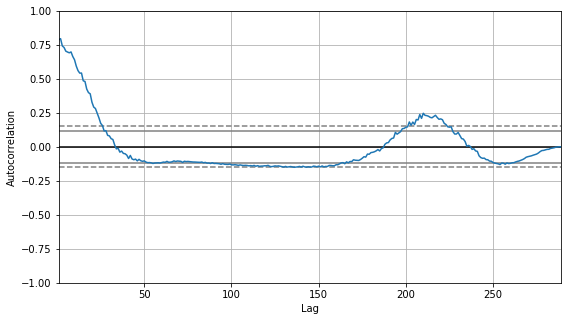

In [33]:
# Seasonality test

plt.rcParams.update({'figure.figsize': (9,5)})
autocorrelation_plot(tmp_df[compart].tolist())
plt.show()

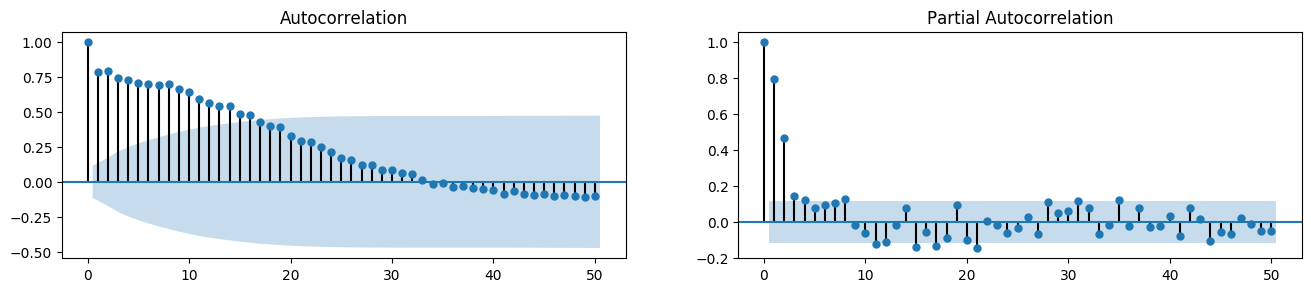

In [34]:
# Autocorrelation and partial autocorrelation

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(tmp_df[compart], nlags=50)
pacf_50 = pacf(tmp_df[compart], nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(tmp_df[compart].tolist(), lags=50, ax=axes[0])
plot_pacf(tmp_df[compart].tolist(), lags=50, ax=axes[1])
plt.show()

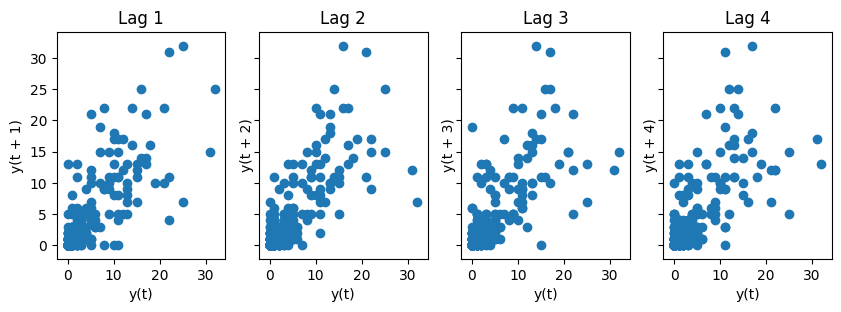

In [35]:
"""
Lag plots:

If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tmp_df[compart], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

plt.show()

In [36]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.1870022526954152
ApproxEn: 0.46881341016855327


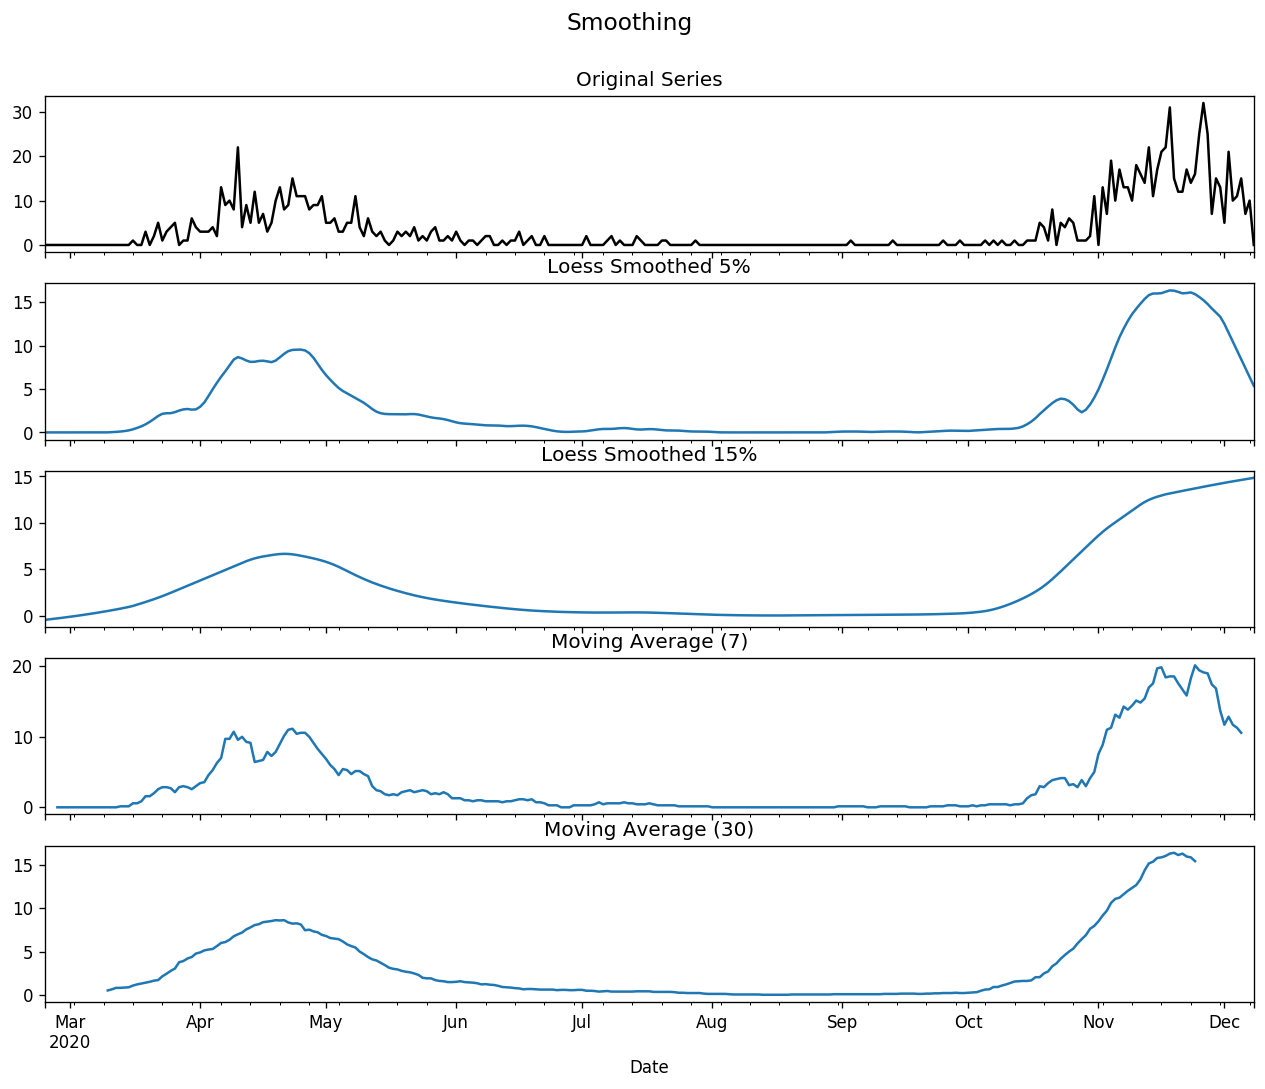

In [37]:
# Smoothing

# 1. Moving Average
df_ma1 = tmp_df[compart].rolling(7, center=True, closed='both').mean()
df_ma2 = tmp_df[compart].rolling(30, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.05)[:, 1], index=tmp_df.index, columns=[compart])
df_loess_15 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.15)[:, 1], index=tmp_df.index, columns=[compart])

# Plot
fig, axes = plt.subplots(5,1, figsize=(13, 10), sharex=True, dpi=120)
tmp_df[compart].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5[compart].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15[compart].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma1.plot(ax=axes[3], title='Moving Average (7)')
df_ma2.plot(ax=axes[4], title='Moving Average (30)')
fig.suptitle('Smoothing', y=0.95, fontsize=14)
plt.show()

In [38]:
"""
Granger causality tests:

Deaths - Month
Deaths - Infected
"""


tmp_df = covidpro_df[covidpro_df.Province == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9052  , p=0.0894  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=2.9358  , p=0.0866  , df=1
likelihood ratio test: chi2=2.9210  , p=0.0874  , df=1
parameter F test:         F=2.9052  , p=0.0894  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6527  , p=0.1934  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=3.3640  , p=0.1860  , df=2
likelihood ratio test: chi2=3.3445  , p=0.1878  , df=2
parameter F test:         F=1.6527  , p=0.1934  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0105  , p=0.3885  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=3.1077  , p=0.3753  , df=3
likelihood ratio test: chi2=3.0909  , p=0.3778  , df=3
parameter F test:         F=1.0105  , p=0.3885  , df_denom=279, df_num=3


In [39]:
gc_res = grangercausalitytests(tmp_df[[compart, 'New_cases']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.1220 , p=0.0000  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=24.3759 , p=0.0000  , df=1
likelihood ratio test: chi2=23.3991 , p=0.0000  , df=1
parameter F test:         F=24.1220 , p=0.0000  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2340  , p=0.0022  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=12.6891 , p=0.0018  , df=2
likelihood ratio test: chi2=12.4166 , p=0.0020  , df=2
parameter F test:         F=6.2340  , p=0.0022  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.9564 , p=0.0000  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=36.7691 , p=0.0000  , df=3
likelihood ratio test: chi2=34.5903 , p=0.0000  , df=3
parameter F test:         F=11.9564 , p=0.0000  , df_denom=279, df_num=3


## Exploration TS: Infected Piemonte

In [40]:
province = "Piemonte"
compart = "nuovi_positivi"
date = 'data'

In [41]:
tmp_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province]

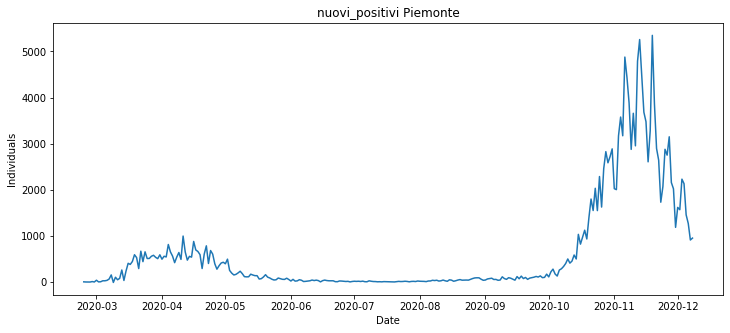

In [42]:
# Visualize TS

plt.figure(figsize=(12,5))
plt.plot(tmp_df[date], tmp_df[compart])
plt.gca().set(title=compart + " " + province, xlabel='Date', ylabel='Individuals')
plt.show()

In [43]:
tmp_df = tmp_df.set_index(date)

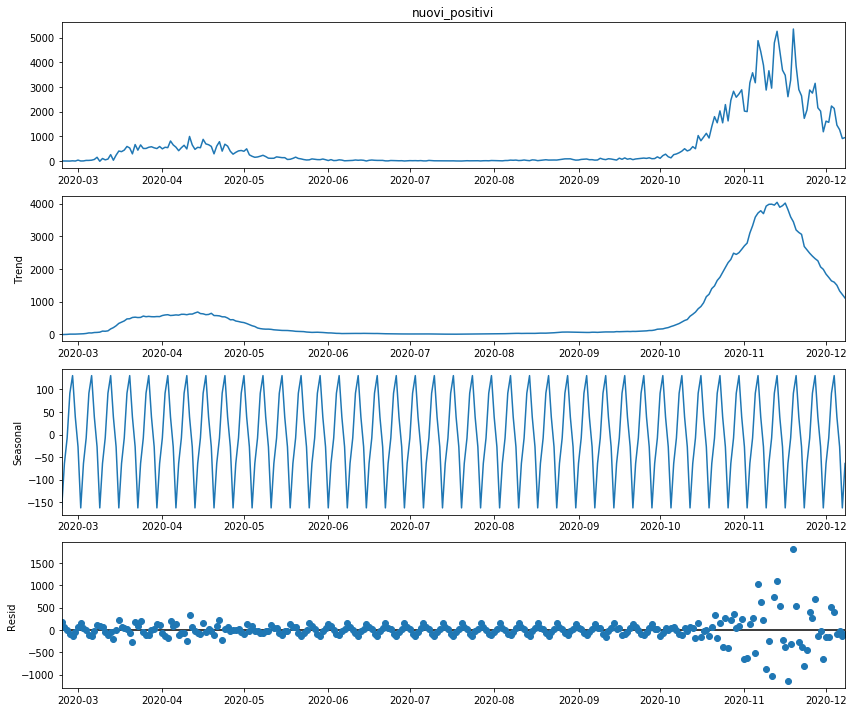

In [44]:
# Decompose TS

# Additive Decomposition
result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (12,10)})
result_add.plot()
plt.show()

In [45]:
# Test for stationarity and trend stationarity

"""
ADF test: null hypothesis is the time series
possesses a unit root and is non-stationary
"""
result = adfuller(tmp_df[compart].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""
KPSS test: opposite of ADF
"""
result = kpss(tmp_df[compart].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.1079325802641784
p-value: 0.025971684522471013
Critial Values:
   1%, -3.4542672521624214
Critial Values:
   5%, -2.87206958769775
Critial Values:
   10%, -2.5723807881747534

KPSS Statistic: 0.701606
p-value: 0.013399
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


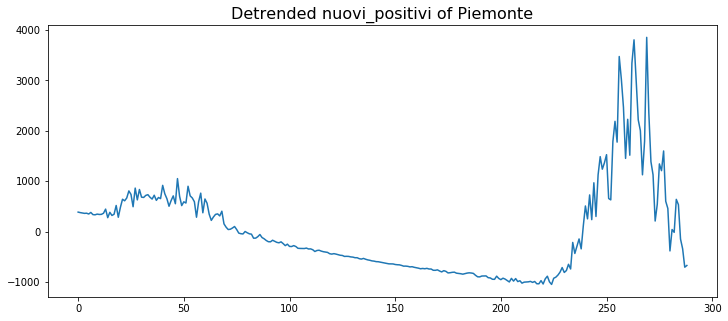

In [46]:
# Detrend by subtracting best leastsq fit
detrended = signal.detrend(tmp_df[compart].values)

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

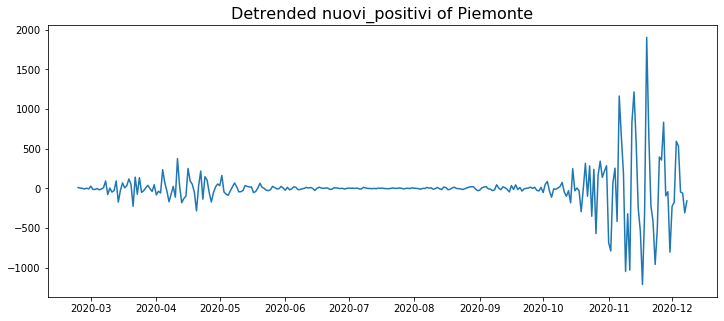

In [47]:
# Detrend by subtracting trend comp

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')
detrended = tmp_df[compart].values - result_add.trend

plt.figure(figsize=(12,5))
plt.plot(detrended)
plt.title('Detrended ' + compart + ' of ' + province, fontsize=16)
plt.show()

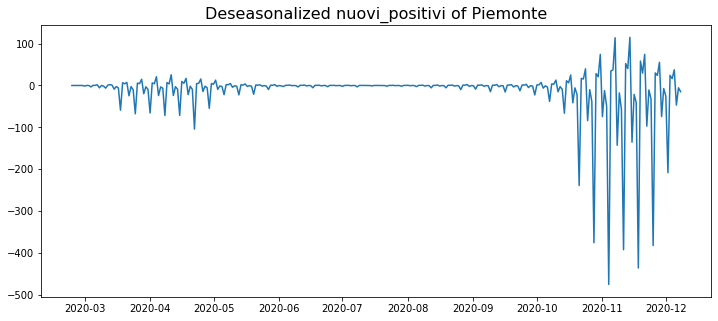

In [48]:
# Deseasonalize by subtracting trend

#result_add = seasonal_decompose(tmp_df[compart], model='additive', extrapolate_trend='freq')

deseasonalized = tmp_df[compart].values / result_add.seasonal

plt.figure(figsize=(12,5))
plt.plot(deseasonalized)
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.plot()
plt.show()

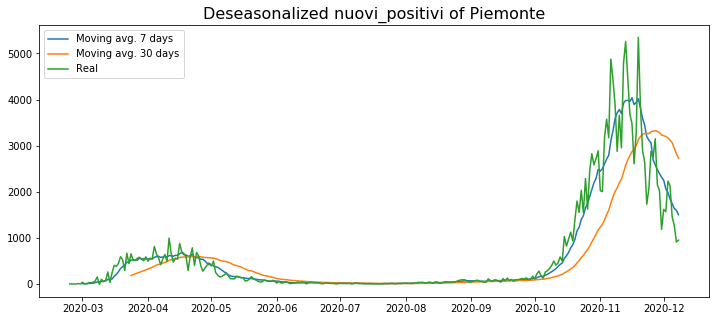

In [49]:
# Deseasonalize by taking mov. avg. with length = seasonal window

plt.figure(figsize=(12,5))
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=7).mean(), label='Moving avg. 7 days')
plt.plot(tmp_df.index, tmp_df[compart].rolling(window=30).mean(), label='Moving avg. 30 days')
plt.plot(tmp_df.index, tmp_df[compart].values, label='Real')
plt.title('Deseasonalized ' + compart + ' of ' + province, fontsize=16)
plt.legend()
plt.show()

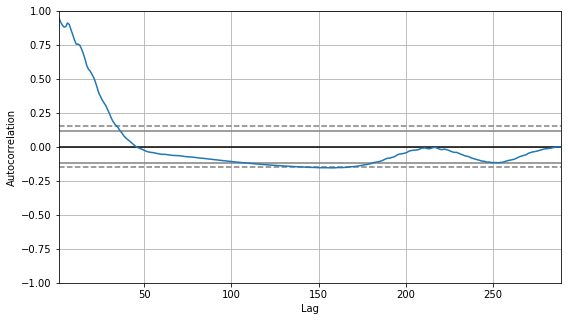

In [50]:
# Seasonality test

plt.rcParams.update({'figure.figsize': (9,5)})
autocorrelation_plot(tmp_df[compart].tolist())
plt.show()

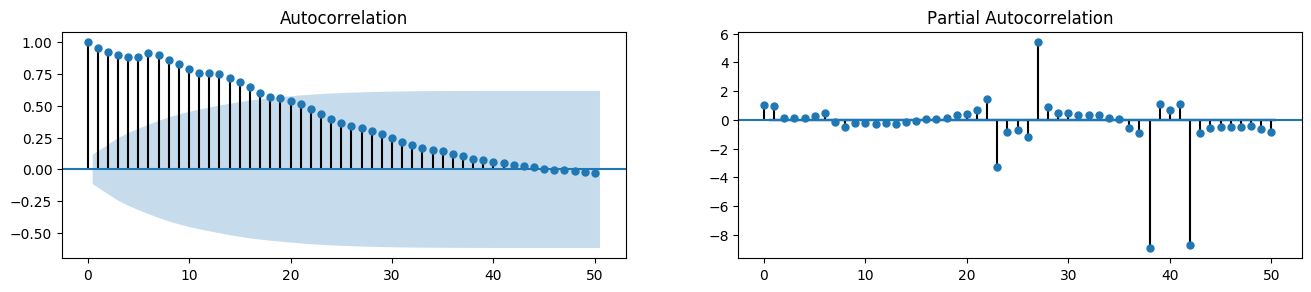

In [51]:
# Autocorrelation and partial autocorrelation

# Calculate ACF and PACF upto 50 lags
acf_50 = acf(tmp_df[compart], nlags=50)
pacf_50 = pacf(tmp_df[compart], nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
plot_acf(tmp_df[compart].tolist(), lags=50, ax=axes[0])
plot_pacf(tmp_df[compart].tolist(), lags=50, ax=axes[1])
plt.show()

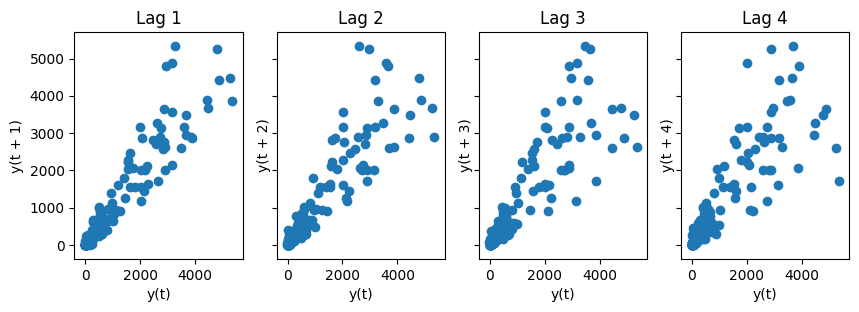

In [52]:
"""
Lag plots:

If points get wide and scattered with increasing lag, 
this means lesser correlation
"""

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tmp_df[compart], lag=i+1, ax=ax)
    ax.set_title('Lag ' + str(i+1))

plt.show()

In [53]:
# Estimate forecastability
print("SampEn:", SampEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values)))
print("ApproxEn:", ApEn(tmp_df[compart].values, m=2, r=0.2*np.std(tmp_df[compart].values))) 

SampEn: 0.05728321600032258
ApproxEn: 0.21818824543933113


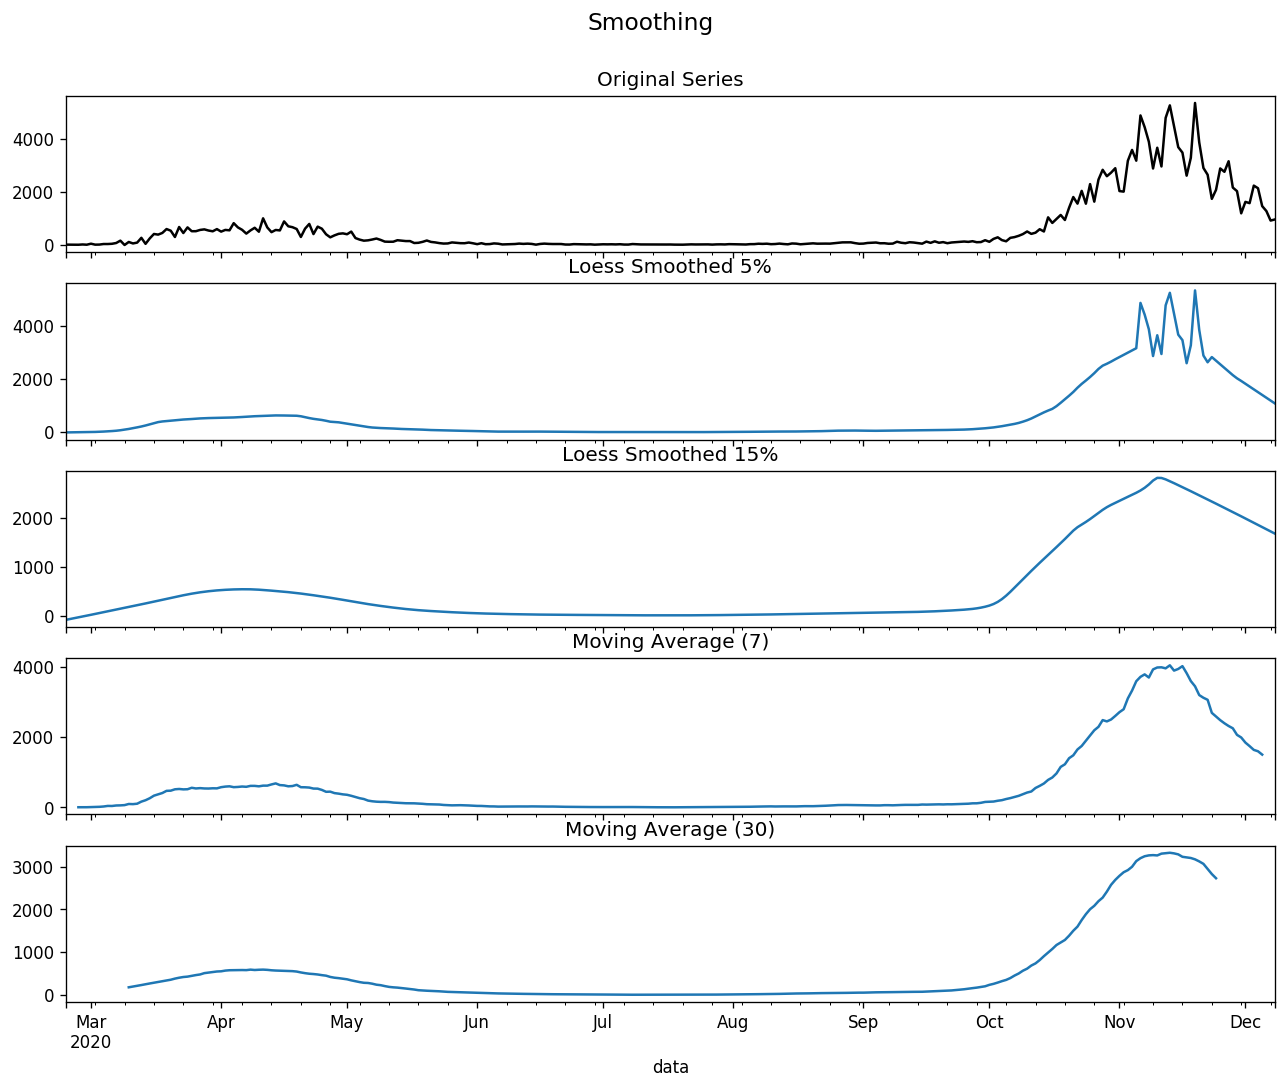

In [54]:
# Smoothing

# 1. Moving Average
df_ma1 = tmp_df[compart].rolling(7, center=True, closed='both').mean()
df_ma2 = tmp_df[compart].rolling(30, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.05)[:, 1], index=tmp_df.index, columns=[compart])
df_loess_15 = pd.DataFrame(lowess(tmp_df[compart], np.arange(len(tmp_df[compart])), frac=0.15)[:, 1], index=tmp_df.index, columns=[compart])

# Plot
fig, axes = plt.subplots(5,1, figsize=(13, 10), sharex=True, dpi=120)
tmp_df[compart].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5[compart].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15[compart].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma1.plot(ax=axes[3], title='Moving Average (7)')
df_ma2.plot(ax=axes[4], title='Moving Average (30)')
fig.suptitle('Smoothing', y=0.95, fontsize=14)
plt.show()

In [55]:
"""
Granger causality tests:

Deaths - Month
Deaths - Infected
"""


tmp_df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province]

tmp_df['month'] = tmp_df[date].dt.month
gc_res = grangercausalitytests(tmp_df[[compart, 'month']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8554  , p=0.0922  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=2.8855  , p=0.0894  , df=1
likelihood ratio test: chi2=2.8711  , p=0.0902  , df=1
parameter F test:         F=2.8554  , p=0.0922  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0543  , p=0.3498  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=2.1461  , p=0.3420  , df=2
likelihood ratio test: chi2=2.1381  , p=0.3433  , df=2
parameter F test:         F=1.0543  , p=0.3498  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2259  , p=0.3006  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=3.7699  , p=0.2874  , df=3
likelihood ratio test: chi2=3.7452  , p=0.2903  , df=3
parameter F test:         F=1.2259  , p=0.3006  , df_denom=279, df_num=3


In [56]:
gc_res = grangercausalitytests(tmp_df[[compart, 'deceduti']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0481  , p=0.8266  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=0.0486  , p=0.8256  , df=1
likelihood ratio test: chi2=0.0486  , p=0.8256  , df=1
parameter F test:         F=0.0481  , p=0.8266  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0083  , p=0.9917  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=0.0169  , p=0.9916  , df=2
likelihood ratio test: chi2=0.0169  , p=0.9916  , df=2
parameter F test:         F=0.0083  , p=0.9917  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0845  , p=0.9685  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=0.2597  , p=0.9674  , df=3
likelihood ratio test: chi2=0.2596  , p=0.9674  , df=3
parameter F test:         F=0.0845  , p=0.9685  , df_denom=279, df_num=3


## Prediction

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100